In [6]:
# --- Standard libraries
import os.path as osp
import pandas as pd
import numpy as np
import pickle as pkl
# --- Matplotlib
import matplotlib.pyplot as plt
#import imageio
import torch
import torch_geometric
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader
# --- XASNet
from XASNet.data import save_split
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.trainer import GNNTrainer
from dataset import XASDataset_mol

In [7]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')

Pytorch version: 2.4.1+cpu
PyG version: 2.5.3


In [9]:
go_spec = torch.load('./cor_xasnet.pt')

/tmp/ipykernel_11915/2473216213.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  go_spec = torch.load('./cor_xasnet.pt')


In [10]:
# --- Print details of the dataset
print(go_spec)
print('------------')
print(f'Number of graphs: {len(go_spec)}')
print(f'Number of features: {go_spec.num_features}')
print('')

# --- Print details of the first molecule/graph in dataset
data = go_spec[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset_mol(317)
------------
Number of graphs: 317
Number of features: 11

Data(x=[32, 11], edge_index=[2, 76], edge_attr=[76, 5], spectrum=[200], idx=[1], smiles='c12[c:2]3[c:1]([H:32])[c:25]([H:41])[c:24]4[c:22]1[c:17]1[c:19]([c:20]([H:39])[c:23]4[H:40])[C:18]([C:21](=[O:26])[O:27][H:42])=[C:16]([H:38])[C:15]4=[C:14]([H:37])[C:12]([H:36])=[C:11]5[C:9]([O:30][H:44])([C:4]2([H:47])[C:6]([O:31][H:46])([C:5]([C:8](=[O:28])[O:29][H:43])=[C:3]3[H:33])[C:7]([H:34])=[C:10]5[H:35])[C:13]41[H:45]')
------------
Number of nodes: 32
Number of edges: 76
Average node degree: 2.38
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [5]:
# --- Create spilt file with the dataset
# --- split into test, validation and test datasets
idxs = save_split(
    path='./processed/xasnet-split_new.npz',
    ndata=len(go_spec),
    ntrain=238,
    nval=30,
    ntest=49,
    save_split=True,
    shuffle=True, 
    print_nsample=True
)

In [6]:
# --- Create variables for each dataset split
train_go = [go_spec[i] for i in idxs['train']]
val_go = [go_spec[i] for i in idxs['val']]
test_go = [go_spec[i] for i in idxs['test']]

# train_go = torch.load('./mol_train.pt')
# val_go = torch.load('./mol_val.pt')
# --- Save datasets splits into dataloaders
train_loader = DataLoader(train_go, batch_size=238, shuffle=True)
val_loader = DataLoader(val_go, batch_size=30, shuffle=True)
test_loader = DataLoader(test_go, batch_size=49, shuffle=False)

print(f'Training dataset length: {len(train_go)}, compiled in {len(train_loader)} loaders')
print(f'Validation dataset length: {len(val_go)}, compiled in {len(val_loader)} loaders')
print(f'Test dataset length: {len(test_go)}, compiled in {len(test_loader)} loaders')

torch.save(test_go, './processed/test_xasnet_cor_new.pt')

Training dataset length: 238, compiled in 1 loaders
Validation dataset length: 30, compiled in 1 loaders
Test dataset length: 49, compiled in 1 loaders


In [7]:
# --- Define cost functions
def RSE_loss(prediction, target):
    dE = (300 - 280) / 200
    nom = torch.sum(dE*torch.pow((target-prediction), 2))
    denom = torch.sum(dE*target)
    return torch.sqrt(nom) / denom 

def RMSE_loss(prediction, target):
    return torch.sqrt(torch.mean((target - prediction)**2))

In [91]:
# --- Set number of epochs to run
num_epochs = 750
# --- Set the learning rate 
lr = 0.01
# --- Milestones to reduce learning rate in steps 
milestones = np.arange(200, 900, 200).tolist()
print(milestones)

[200, 400, 600, 800]


##### XASNet GNN

In [39]:
# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [8, 64, 128], # input nodes for each layer
    out_channels = [64, 128, 256], # output nodes for each layer
    num_targets = 200, # nodes for final output
    num_layers = 3, # number of total layers
    dropout = 0.1,
    heads = 0
).to(device)

# --- Set model name
model_name = 'xasnet_' + xasnet_gnn.gnn_name +'_model'

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

2
4
6
Model is not loaded.


In [40]:
# --- View the details of the created model
print(xasnet_gnn)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GNN(
  (interaction_layers): ModuleList(
    (0): GCNConv(8, 64)
    (1): ReLU(inplace=True)
    (2): GCNConv(64, 128)
    (3): ReLU(inplace=True)
    (4): GCNConv(128, 256)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=256, out_features=200, bias=True)
)
----
 Model will be trained on: cuda


##### XASNet GAT

In [65]:
# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=8,
    in_channels=[64, 128],
    out_channels=[128, 256],
    targets=200,
    n_layers=2,
    n_heads=4,
    gat_type='gatv2',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Set name for ML model
model_name = 'xasnet-GAT_' + xasnet_gat.gat_type + '_model'

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [66]:
# --- View the details of the created model
print(xasnet_gat)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GAT(
  (pre_layer): LinearLayer(
    (linear): Linear(in_features=8, out_features=64, bias=False)
    (_activation): ReLU(inplace=True)
  )
  (res_block): Residual_block(
    (res_layers): Sequential(
      (0): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (1): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (2): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (3): LinearLayer(
        (linear): Linear(in_features=64, out_features=64, bias=False)
        (_activation): ReLU(inplace=True)
      )
    )
  )
  (gat_layers): ModuleList(
    (0): GATv2Conv(64, 128, heads=4)
    (1): ReLU(inplace=True)
    (2): GATv2Conv(512, 256, heads=1)
  )
  (lstm): LSTM(512, 128, num_layers=3, batch_first=True, bidirectional=

##### XASNet GraphNet

In [87]:
# --- Set name for ML model
model_name = 'xasnet_graphnet_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Set a manual seed for reproducibility
torch.manual_seed(1994)

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=8,
    edge_dim=5,
    hidden_channels=64,
    out_channels=128,
    gat_hidd=64,
    gat_out=128,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [88]:
# --- View the details of the created model
print(xasnet_graphnet)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GraphNet(
  (graphnets): ModuleList(
    (0): GraphNetwork(
      (gatencoder): GATEncoder(
        (gats): ModuleList(
          (0): GATv2Conv(8, 64, heads=3)
          (1): ReLU(inplace=True)
          (2): GATv2Conv(192, 64, heads=3)
          (3): ReLU(inplace=True)
          (4): GATv2Conv(192, 64, heads=3)
          (5): ReLU(inplace=True)
          (6): GATv2Conv(192, 128, heads=1)
        )
      )
      (node_model): NodeModel(
        (mlp): Sequential(
          (0): Linear(in_features=146, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=128, bias=True)
          (3): ReLU(inplace=True)
          (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (edge_model): EdgeModel(
        (mlp): Sequential(
          (0): Linear(in_features=389, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=128, bias=True)
         

##### Train model

In [89]:
chosen_model = xasnet_graphnet

In [90]:
# --- Set additional ML parameters
optimizer = torch.optim.Adam(chosen_model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.99), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.8)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

In [92]:
# --- Create trainier
trainer = GNNTrainer(model = chosen_model,
                     model_name = model_name,
                     device = device,
                     metric_path = './metrics/' + model_name)

# --- Train the ML model        
trainer.train_val(train_loader, val_loader, optimizer, RSE_loss,
                  scheduler, num_epochs, write_every=1, train_graphnet=True)

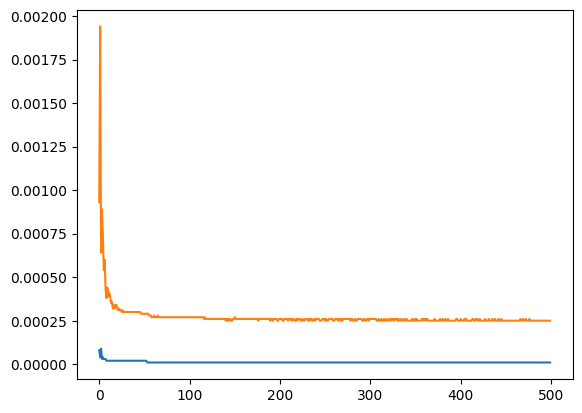

In [33]:
df_train = pd.read_csv('./metrics/' + model_name + '/train_metrics.csv')
df_val = pd.read_csv('./metrics/' + model_name + '/val_metrics.csv')
plt.plot(df_train['epoch'], df_train['loss'])
plt.plot(df_val['epoch'], df_val['loss'])
plt.show()